In [92]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance
pd.set_option('display.max_columns', None)


from lightgbm.sklearn import LGBMRegressor
from lightgbm.sklearn import LGBMClassifier

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

import math


In [93]:
import random, os 
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #pythonhashseed 환경변수 설정
    np.random.seed(seed)

seed_everything(42)

In [94]:
data = pd.read_csv("/data/ephemeral/home/upstage-ml-regression-07/house_price_pred/notebooks/SJH/data/0122_total_data.csv")
data.head(1)

,index,복도유형,난방방식,전용면적,계약일,층,건축년도,x,y,아파트명,계약년월,도로명_x,도로명주소,mean_지상층수,sum_세대수,sum_연면적,mean_연면적,mean_높이,sum_건축면적,mean_건축면적,부속건축물수,target,동,시군구,bus_min_dist,sub_min_dist,한강거리,소비자전세물가지수,소비자월세물가지수,총인구수,연GDP,기준금리,dist_to_nearest_school,bus_count_500,bus_count_1000,bus_count_1500,bus_count_2000,is_station_area,대장아파트_거리,도로명,전용면적_filtered,is_test,이전가격,매매수급동향,도로명_split,주차대수,k-전체세대수,세대수당_주차대수,년도별_세대수당_평균_주차대수,건물나이,최고층,최저층,빌딩간격,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio
0,1000333,계단식,개별난방,75.73,1,3,1997,126.827102,37.54024,우림,201703,10,서울특별시 양천구 10,16.725022,1041.739764,120478.247245,14143.615087,38.58524,12803.545889,1150.29738,6.001762,24806.0,신월동,서울특별시 양천구 신월동,0.123109,1.100174,0.657924,96.34,100.19,475018,41374,1.25,0.116144,19,27,79,82,0,4.354641,10,7.0,0,24806.0,101.0,10,262.0,270.0,0.97037,0.853052,26,6,3,3,0.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.3915,50.592857,52.183484


In [95]:
train = data[data['is_test'] == 0]
test = data[data['is_test'] == 1]

In [96]:
train = train.sort_values(by='index')
test = test.sort_values(by='index')

In [97]:
train = train.set_index('index')
test = test.set_index('index')

In [98]:
train.drop(columns='is_test', inplace=True)
test.drop(columns='is_test', inplace=True)

In [99]:
train.columns

Index(['복도유형', '난방방식', '전용면적', '계약일', '층', '건축년도', 'x', 'y', '아파트명', '계약년월',
       '도로명_x', '도로명주소', 'mean_지상층수', 'sum_세대수', 'sum_연면적', 'mean_연면적',
       'mean_높이', 'sum_건축면적', 'mean_건축면적', '부속건축물수', 'target', '동', '시군구',
       'bus_min_dist', 'sub_min_dist', '한강거리', '소비자전세물가지수', '소비자월세물가지수',
       '총인구수', '연GDP', '기준금리', 'dist_to_nearest_school', 'bus_count_500',
       'bus_count_1000', 'bus_count_1500', 'bus_count_2000', 'is_station_area',
       '대장아파트_거리', '도로명', '전용면적_filtered', '이전가격', '매매수급동향', '도로명_split',
       '주차대수', 'k-전체세대수', '세대수당_주차대수', '년도별_세대수당_평균_주차대수', '건물나이', '최고층',
       '최저층', '빌딩간격', '거래날차이', '2016_ratio', '2017_ratio', '2018_ratio',
       '2019_ratio', '2020_ratio', '2021_ratio', '2022_ratio', '2023_ratio'],
      dtype='object')

In [100]:
drop_cols = ['계약일','도로명주소','도로명_x','mean_높이','bus_min_dist','sub_min_dist','소비자전세물가지수','소비자월세물가지수','총인구수','연GDP','bus_count_1500','bus_count_2000','도로명','도로명_split','전용면적_filtered','매매수급동향','주차대수','k-전체세대수','세대수당_주차대수','년도별_세대수당_평균_주차대수','건물나이','2016_ratio','2017_ratio','2018_ratio','2019_ratio','2021_ratio','2022_ratio','2023_ratio']
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

In [101]:
train.shape, test.shape

((1118822, 32), (9272, 32))

In [102]:
train['구'] = train['시군구'].apply(lambda x: x.split()[1])
test['구'] = test['시군구'].apply(lambda x: x.split()[1])
train.drop(columns=['시군구'], inplace=True)
test.drop(columns=['시군구'], inplace=True)

In [103]:
train = train[train['계약년월'] > 201912]
train.shape

(156590, 32)

In [104]:
len(train[train['target'] < 200000]), len(train[(train['target'] >= 200000) & (train['target'] < 500000)]), len(train[(train['target'] >= 500000)])

(146476, 9722, 392)

In [105]:
'''
 x < 200,000 : 0
 200,000 < x < 500,000 : 1
 x > 500,000 : 2
''' 

'\n x < 200,000 : 0\n 200,000 < x < 500,000 : 1\n x > 500,000 : 2\n'

In [106]:
train['is_outlier'] = 0
train.loc[train['target'] < 200000, 'is_outlier'] = 0
train.loc[(train['target'] >= 200000) & (train['target'] < 500000), 'is_outlier'] = 1
train.loc[(train['target'] >= 500000), 'is_outlier'] = 2

In [107]:
train.columns

Index(['복도유형', '난방방식', '전용면적', '층', '건축년도', 'x', 'y', '아파트명', '계약년월',
       'mean_지상층수', 'sum_세대수', 'sum_연면적', 'mean_연면적', 'sum_건축면적', 'mean_건축면적',
       '부속건축물수', 'target', '동', '한강거리', '기준금리', 'dist_to_nearest_school',
       'bus_count_500', 'bus_count_1000', 'is_station_area', '대장아파트_거리',
       '이전가격', '최고층', '최저층', '빌딩간격', '거래날차이', '2020_ratio', '구', 'is_outlier'],
      dtype='object')

In [108]:
categorical_features = list(train.dtypes[train.dtypes == "object"].index) #object값 list에 넣음
# 추출된 문자열 변수 확인
display(categorical_features) #object값 출력

['복도유형', '난방방식', '아파트명', '동', '구']

In [109]:
def label_encoding(train_x, test, categorical_features):
    # 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
    label_encoders = {}

    # Implement Label Encoding
    for col in tqdm( categorical_features ):
        lbl = LabelEncoder()

        # Label-Encoding을 fit
        lbl.fit(train_x[col].astype(str) )
        train_x[col] = lbl.transform(train_x[col].astype(str))
        label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

        # # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
        for label in np.unique(test[col]):
            if label not in lbl.classes_: # unseen label 데이터인 경우
                lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

        test[col] = lbl.transform(test[col].astype(str))

label_encoding(train_x=train, test=test, categorical_features=categorical_features)

100%|██████████| 5/5 [00:00<00:00, 16.58it/s]


In [110]:
train.columns

Index(['복도유형', '난방방식', '전용면적', '층', '건축년도', 'x', 'y', '아파트명', '계약년월',
       'mean_지상층수', 'sum_세대수', 'sum_연면적', 'mean_연면적', 'sum_건축면적', 'mean_건축면적',
       '부속건축물수', 'target', '동', '한강거리', '기준금리', 'dist_to_nearest_school',
       'bus_count_500', 'bus_count_1000', 'is_station_area', '대장아파트_거리',
       '이전가격', '최고층', '최저층', '빌딩간격', '거래날차이', '2020_ratio', '구', 'is_outlier'],
      dtype='object')

In [111]:
train_x = train.drop(columns=['target', 'is_outlier'])
train_y = train['is_outlier']

In [112]:
# 데이터셋 분할

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42, stratify=train_y) # 0.05 -> k-fold 시 사용하는 테크닉
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(125272, 31) (125272,) (31318, 31) (31318,)


In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [114]:
y_pred = clf.predict(X_val)

In [115]:
# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     29295
           1       0.91      0.88      0.89      1944
           2       0.90      0.76      0.82        79

    accuracy                           0.99     31318
   macro avg       0.93      0.88      0.90     31318
weighted avg       0.99      0.99      0.99     31318



In [116]:
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Confusion Matrix:
[[29142   153     0]
 [  236  1701     7]
 [    0    19    60]]


In [117]:
y_val.value_counts()

0    29295
1     1944
2       79
Name: is_outlier, dtype: int64

In [118]:
# 데이터셋 분할

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.05, random_state=42, stratify=train_y) # 0.05 -> k-fold 시 사용하는 테크닉
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(148760, 31) (148760,) (7830, 31) (7830,)


In [119]:
from sklearn.metrics import f1_score
evaluation_metric = f1_score

In [120]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.  # bayesian optimization
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 10)
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 10, 25])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_float('max_features', 0.5, 0.8)

    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   max_features=max_features,
                                   random_state=42)

    # K-Fold Cross validation
    folds = KFold(n_splits=K, random_state=42, shuffle=True)
    losses = []

    for train_idx, val_idx in tqdm(folds.split(X, y)):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = evaluation_metric(y_val, preds, average='weighted')
        losses.append(loss)

    return np.mean(losses)

In [123]:
K = 5
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

study = optuna.create_study(direction="minimize")
study.optimize(opt_func, n_trials=10)

[I 2024-01-23 07:20:37,018] A new study created in memory with name: no-name-8f10c7de-f99f-4fea-9087-ad91ac3f8e1b
5it [04:40, 56.06s/it]
[I 2024-01-23 07:25:17,316] Trial 0 finished with value: 0.985013841741506 and parameters: {'n_estimators': 161, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 0.589993700994916}. Best is trial 0 with value: 0.985013841741506.
5it [01:29, 17.86s/it]
[I 2024-01-23 07:26:46,618] Trial 1 finished with value: 0.9847896546410242 and parameters: {'n_estimators': 58, 'max_depth': 8, 'min_samples_split': 25, 'min_samples_leaf': 7, 'max_features': 0.5470698534691593}. Best is trial 1 with value: 0.9847896546410242.
5it [05:31, 66.40s/it]
[I 2024-01-23 07:32:18,620] Trial 2 finished with value: 0.9850176989163348 and parameters: {'n_estimators': 150, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 0.7676285240674918}. Best is trial 1 with value: 0.9847896546410242.
5it [08:31, 102.40s/it]
[I 2024-

In [124]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 0.9834
Best params:  {'n_estimators': 70, 'max_depth': 5, 'min_samples_split': 25, 'min_samples_leaf': 5, 'max_features': 0.6144061144621422}


In [125]:
# model finalization

print("Validation ACC")
best_params = study.best_params
best_model = RandomForestClassifier(**best_params,
                                   random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)

Validation ACC


In [126]:
# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7324
           1       0.88      0.84      0.86       486
           2       0.89      0.85      0.87        20

    accuracy                           0.98      7830
   macro avg       0.92      0.89      0.91      7830
weighted avg       0.98      0.98      0.98      7830



In [127]:
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Confusion Matrix:
[[7271   53    0]
 [  77  407    2]
 [   0    3   17]]


                   Feature  Importance
24                    이전가격    0.853163
29              2020_ratio    0.067094
2                     전용면적    0.036568
30                       구    0.009238
8                     계약년월    0.008475
11                 sum_연면적    0.007695
9                mean_지상층수    0.002667
4                     건축년도    0.002432
10                 sum_세대수    0.002199
23                대장아파트_거리    0.001487
6                        y    0.001406
27                    빌딩간격    0.001363
5                        x    0.000888
18                    기준금리    0.000754
1                     난방방식    0.000683
3                        층    0.000624
13                sum_건축면적    0.000537
14               mean_건축면적    0.000400
17                    한강거리    0.000385
16                       동    0.000288
28                   거래날차이    0.000285
12                mean_연면적    0.000275
19  dist_to_nearest_school    0.000219
21          bus_count_1000    0.000213
20           bus_count_50

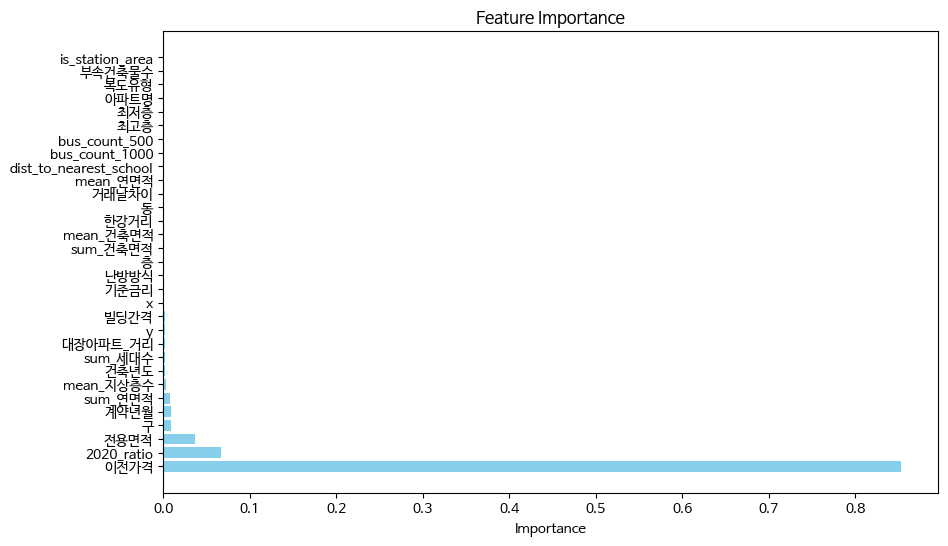

In [128]:
feature_importance = best_model.feature_importances_

# Get the names of the features
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance
print(feature_importance_df)

# Optionally, plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [129]:
# model finalization
best_params = study.best_params
best_model = RandomForestClassifier(**best_params,
                          random_state=42)
best_model.fit(train_x, train_y)


RandomForestClassifier(max_depth=5, max_features=0.6144061144621422,
                       min_samples_leaf=5, min_samples_split=25,
                       n_estimators=70, random_state=42)

                   Feature  Importance
24                    이전가격    0.858962
29              2020_ratio    0.069151
2                     전용면적    0.034296
30                       구    0.009279
8                     계약년월    0.008633
11                 sum_연면적    0.004002
10                 sum_세대수    0.002826
1                     난방방식    0.001748
4                     건축년도    0.001482
23                대장아파트_거리    0.001365
6                        y    0.001053
9                mean_지상층수    0.000916
5                        x    0.000827
17                    한강거리    0.000734
18                    기준금리    0.000651
3                        층    0.000581
13                sum_건축면적    0.000545
14               mean_건축면적    0.000404
28                   거래날차이    0.000371
12                mean_연면적    0.000303
15                  부속건축물수    0.000299
21          bus_count_1000    0.000260
27                    빌딩간격    0.000227
26                     최저층    0.000189
19  dist_to_nearest_schoo

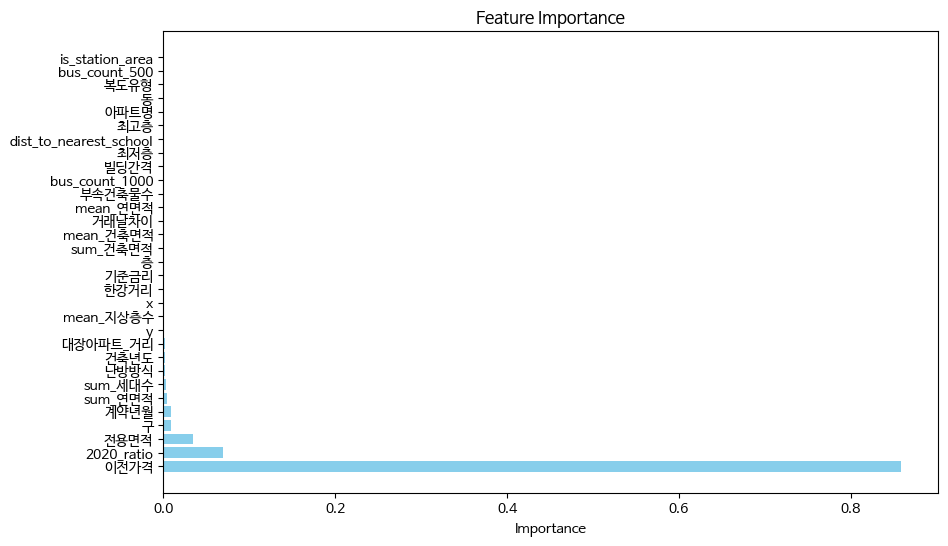

In [130]:
feature_importance = best_model.feature_importances_

# Get the names of the features
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance
print(feature_importance_df)

# Optionally, plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [131]:
# Save the model to a file using pickle
with open('/data/ephemeral/home/upstage-ml-regression-07/house_price_pred/notebooks/SJH/outlier_rf.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

In [132]:
test.drop(columns=['target'], inplace=True)

In [133]:
pred = best_model.predict(test)
test['is_outlier'] = pred 

In [134]:
test['is_outlier'].value_counts()

0    9010
1     255
2       7
Name: is_outlier, dtype: int64

In [135]:
train.to_csv("/data/ephemeral/home/upstage-ml-regression-07/house_price_pred/notebooks/SJH/data/outlier_train.csv", index=False)
test.to_csv("/data/ephemeral/home/upstage-ml-regression-07/house_price_pred/notebooks/SJH/data/outlier_test.csv", index=False)